# Statistical foundation of machine learning

In [1]:
import numpy as np

from preprocessing import (
    create_time_windows,
    create_labels)

## Loading raw data

In [ ]:
# loading raw data
PATH = f'/Users/marco/PROJECTS/data/'
DATASET = 'freemoves' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'data/freemoves/freemoves_dataset_X.npy'

## (Optional) Signal filtering

if you plan to filter your sEMG signals, it is recommended to perform
this preprocessing step directly on the continuous raw data prior to window extraction or feature
computation. Note that this step is completely optional but may improve your results.

## (0.5 point) Dataset preparation and augmentation through overlapping windows

You should first segment your sEMG signals into smaller windows of fixed size k = 500. These windows should be created with a chosen degree of overlap, which you can adjust based on the computational and memory resources available to you. Keep in mind that a larger overlap results in a greater number of samples and thus a larger dataset to train your models but to the cost of increasing computational demands.

In [ ]:
# extracting time windows and labels
size = 500
step = 250
X_windows = create_time_windows(X, size, step) # shape (5, n_windows, 8, 500)
Y_labels = create_labels(Y, size, step) # shape (5, n_windows, 51)

## (1 point) Cross-validation strategy

Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation. Provide a detailed justification showing that your validation sets remain completely independent from the training set. Include reasoning or evidence demonstrating explicitly that your chosen partitioning strategy prevents data leakage or bias, ensuring the reliability and generalizability of your model performance estimates.

In [ ]:
X_train_val = X_windows[:4]
Y_train_val = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

X_train_val.shape[0]*X_train_val.shape[1]

4316

## (3 points) Baseline approach

Create a custom class inheriting from scikit-learn’s `BaseEstimator`
and `TransformerMixin` that implements the extraction of common time-domain features described
in section 3.1. Note that the features described in Section 3.1 represent the minimal required set. We
encourage you to include additional features or preprocessing steps if you would like to further improve your model performances. Select at least two different regression models, compare their cross-validated performance, and evaluate their feature importances. For both models, perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE).
Clearly document this process in your notebook, discussing the outcomes in detail. Finally, create a
scikit-learn `Pipeline` that integrates your custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.
Using visualizations and tables to illustrate your findings, and employing formulas or pseudo-code
to explain the feature selection procedure, is strongly encouraged. Note that one-third of the score
will depend on the quality and clarity of your documentation.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet
from performance_metrics import RMSE, NMSE
from non_nn_transformers import TimeDomainTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
import pyriemann
import pyriemann.regression

### Time domain pipelines

In [ ]:
pipeline0 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('regressor', ElasticNet())
    ]
)

pipeline1 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('kernel_ridge', KernelRidge(
            kernel='linear'
        ))
    ]
)

pipeline2 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('multioutput_svr', MultiOutputRegressor(SVR(
            kernel = 'sigmoid'
        )))
    ]
)

pipeline3 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('decision_tree', DecisionTreeRegressor())
    ]
)

pipeline4 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('extra_tree', ExtraTreeRegressor())
    ]
)

pipeline5 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('random_forest', RandomForestRegressor(
            n_estimators = 30
        ))
    ]
)

### Riemannian geometry pipelines

In [ ]:
# # ----- Riemannian geometry of covariance matrices ----- #
pipeline6 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('rvs', MultiOutputRegressor(pyriemann.regression.SVR()))
    ]
)

pipeline7 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('projection', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('kernel_ridge', KernelRidge(
            kernel='laplacian'))
    ]
)

pipeline8 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('projection', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', RandomForestRegressor())
    ]
)

pipeline9 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('projection', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', Lasso())
    ]
)

In [ ]:
print('Kernels for ridge:')
display({'additive_chi2', 'polynomial', 'laplacian', 'poly', 'sigmoid', 'precomputed', 'cosine', 'rbf', 'linear', 'chi2'})
print('Kernels for SVR:')
display({'linear', 'poly', 'rbf', 'sigmoid'})

Kernels for ridge:


{'additive_chi2',
 'chi2',
 'cosine',
 'laplacian',
 'linear',
 'poly',
 'polynomial',
 'precomputed',
 'rbf',
 'sigmoid'}

Kernels for SVR:


{'linear', 'poly', 'rbf', 'sigmoid'}

### Ensemble estimators

### Pipeline validation

In [ ]:
pipeline = pipeline8 # change this to validate another pipeline

results = {}
for fold in range(4):
    train_idx = [0,1,2,3]
    train_idx.remove(fold)
    val_idx = fold

    X_train = X_train_val[train_idx].reshape(-1, *X_train_val.shape[2:])
    Y_train = Y_train_val[train_idx].reshape(-1, *Y_train_val.shape[2:])
    X_val = X_train_val[val_idx]
    Y_val = Y_train_val[val_idx]
    
    pipeline.fit(X_train, Y_train)
    Y_train_pred = pipeline.predict(X_train)
    Y_val_pred = pipeline.predict(X_val)
    print(f"Fold {fold+1}\n.\
          train RMSE:\t{RMSE(Y_train_pred, Y_train):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train):.4f}\n.\
            val RMSE:\t{RMSE(Y_val_pred, Y_val):.4f}\tval NMSE:\t{NMSE(Y_val_pred, Y_val):.4f}")
    
    results[fold] = {
        'train_RMSE': RMSE(Y_train_pred, Y_train),
        'train_NMSE': NMSE(Y_train_pred, Y_train),
        'val_RMSE': RMSE(Y_val_pred, Y_val),
        'val_NMSE': NMSE(Y_val_pred, Y_val),
    }

mean_val_RMSE = np.mean([dic['val_RMSE'] for dic in results.values()])
mean_val_NMSE = np.mean([dic['val_NMSE'] for dic in results.values()])
print('Mean val RMSE:', mean_val_RMSE)
print('Mean val NMSE:', mean_val_NMSE)

Fold 1
.          train RMSE:	10.0972	train NMSE:	0.5801
.            val RMSE:	10.6078	val NMSE:	0.8467
Fold 2
.          train RMSE:	9.8329	train NMSE:	0.6685
.            val RMSE:	13.1439	val NMSE:	0.9440
Fold 3
.          train RMSE:	9.8429	train NMSE:	0.5913
.            val RMSE:	10.9303	val NMSE:	0.6879
Fold 4
.          train RMSE:	10.2128	train NMSE:	0.5918
.            val RMSE:	9.9722	val NMSE:	0.8481
Mean val RMSE: 11.163537886072161
Mean val NMSE: 0.831652206705449


### Visualizing predictions to unseen data

In [ ]:
X_train_val_flat = X_train_val.reshape(-1, *X_train_val.shape[2:])
Y_train_val_flat = Y_train_val.reshape(-1, *Y_train_val.shape[2:])

pipeline.fit(X_train_val_flat, Y_train_val_flat)
Y_train_pred = pipeline.predict(X_train_val_flat)
Y_test_pred = pipeline.predict(X_test)

print(f"train RMSE:\t{RMSE(Y_train_pred, Y_train_val_flat):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train_val_flat):.4f}\ntest RMSE:\t{RMSE(Y_test_pred, Y_test):.4f}\ttest NMSE:\t{NMSE(Y_test_pred, Y_test):.4f}")

train RMSE:	10.0867	train NMSE:	0.6100
test RMSE:	8.6447	test NMSE:	0.6716


RMSE for bone 0: 6.043363053121082
NMSE for bone 0: 0.6939582637848126


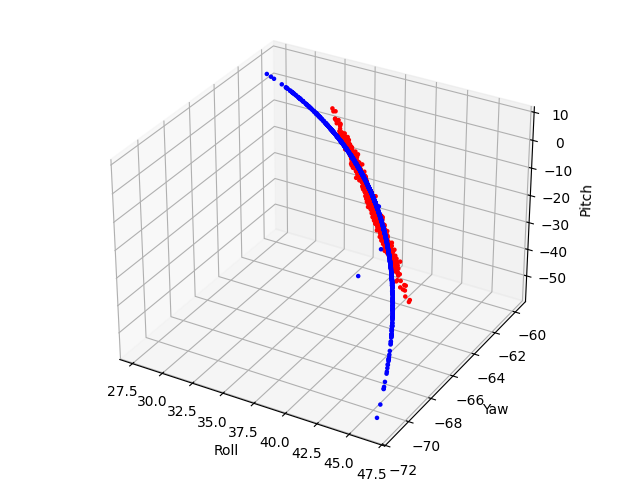

In [ ]:
from visualization_tools import scatter_3d_points
import matplotlib.pyplot as plt
%matplotlib ipympl

bone = 0
Y_true_bone = Y_test[:,3*bone:3*(bone+1)]
Y_pred_bone = Y_test_pred[:,3*bone:3*(bone+1)]

print(f'RMSE for bone {bone}:', RMSE(Y_pred_bone, Y_true_bone))
print(f'NMSE for bone {bone}:', NMSE(Y_pred_bone, Y_true_bone))

ax = scatter_3d_points(Y_true_bone, color = 'b')
scatter_3d_points(Y_pred_bone, color = 'r', ax = ax)
# ax.set_xlim3d(-50, 50)
# ax.set_ylim3d(-50, 50)
# ax.set_zlim3d(-50, 50)
plt.show()